In [1]:

import sys

import os
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader.loader import load_buggy_dataset, load_stable_dataset, get_dataset_paths

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset('train')


Loading sample train data...


In [22]:
from llm_models.openai_model import OpenAILLMModel, evaluate_correction
from tqdm import tqdm
def evaluate_corrections_batch(buggy_codes, traceback_errors, groundtruth_codes, 
                             correction_prompt=None, model="gpt-4.1"):
    """
    Evaluate corrections for multiple code samples.
    
    Args:
        buggy_codes (list): List of buggy code strings
        traceback_errors (list): List of traceback error strings
        groundtruth_codes (list): List of ground truth corrected code strings
        correction_prompt (str, optional): Custom correction prompt. If None, uses default
        model (str): The LLM model to use for corrections
    
    Returns:
        list: List of corrected code strings
    """
    if correction_prompt is None:
        correction_prompt = """You are a Python code correction expert. 
Given a piece of buggy code and its error traceback, please correct the code.
Focus on fixing the specific error mentioned in the traceback."""
    
    corrected_codes = []
    
    for i, (buggy_code, traceback_error, groundtruth_code) in tqdm(
        enumerate(zip(buggy_codes, traceback_errors, groundtruth_codes)),
        total=len(buggy_codes),
        desc="Processing corrections"
    ):
        # Evaluate the correction using the evaluate_correction function
        corrected_code = evaluate_correction(
            prompt=correction_prompt,
            buggy_code=buggy_code,
            traceback_error=traceback_error,
            model=model
        )
        
        corrected_codes.append(corrected_code)
        
        # # Display the results for this sample
        # print("=== ORIGINAL BUGGY CODE ===")
        # print(buggy_code)
        # print("\n=== TRACEBACK ERROR ===")
        # print(traceback_error)
        # print("\n=== CORRECTED CODE ===")
        # print(corrected_code)
        # print("\n" + "="*50 + "\n")
    
    return corrected_codes


In [23]:
# Example usage with the first 10 samples
sample_rows = buggy_train_df.head(10)  # Get first 10 rows as examples

# Extract the buggy codes, traceback errors, and groundtruth codes
buggy_codes = sample_rows['before_merge'].tolist()
traceback_errors = sample_rows['full_traceback'].tolist()
groundtruth_codes = sample_rows['after_merge'].tolist()

# Use the new function
corrected_codes = evaluate_corrections_batch(
    buggy_codes=buggy_codes,
    traceback_errors=traceback_errors,
    groundtruth_codes=groundtruth_codes,
    model="gpt-4.1"
)

Processing corrections: 100%|██████████| 10/10 [00:30<00:00,  3.01s/it]


/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_4298/3632701692.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast],
/var/folders/2p/yszv_4ds72bb4gcspfnbc3vw0000gn/T/ipykernel_4298/3632701692.py:66: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text],


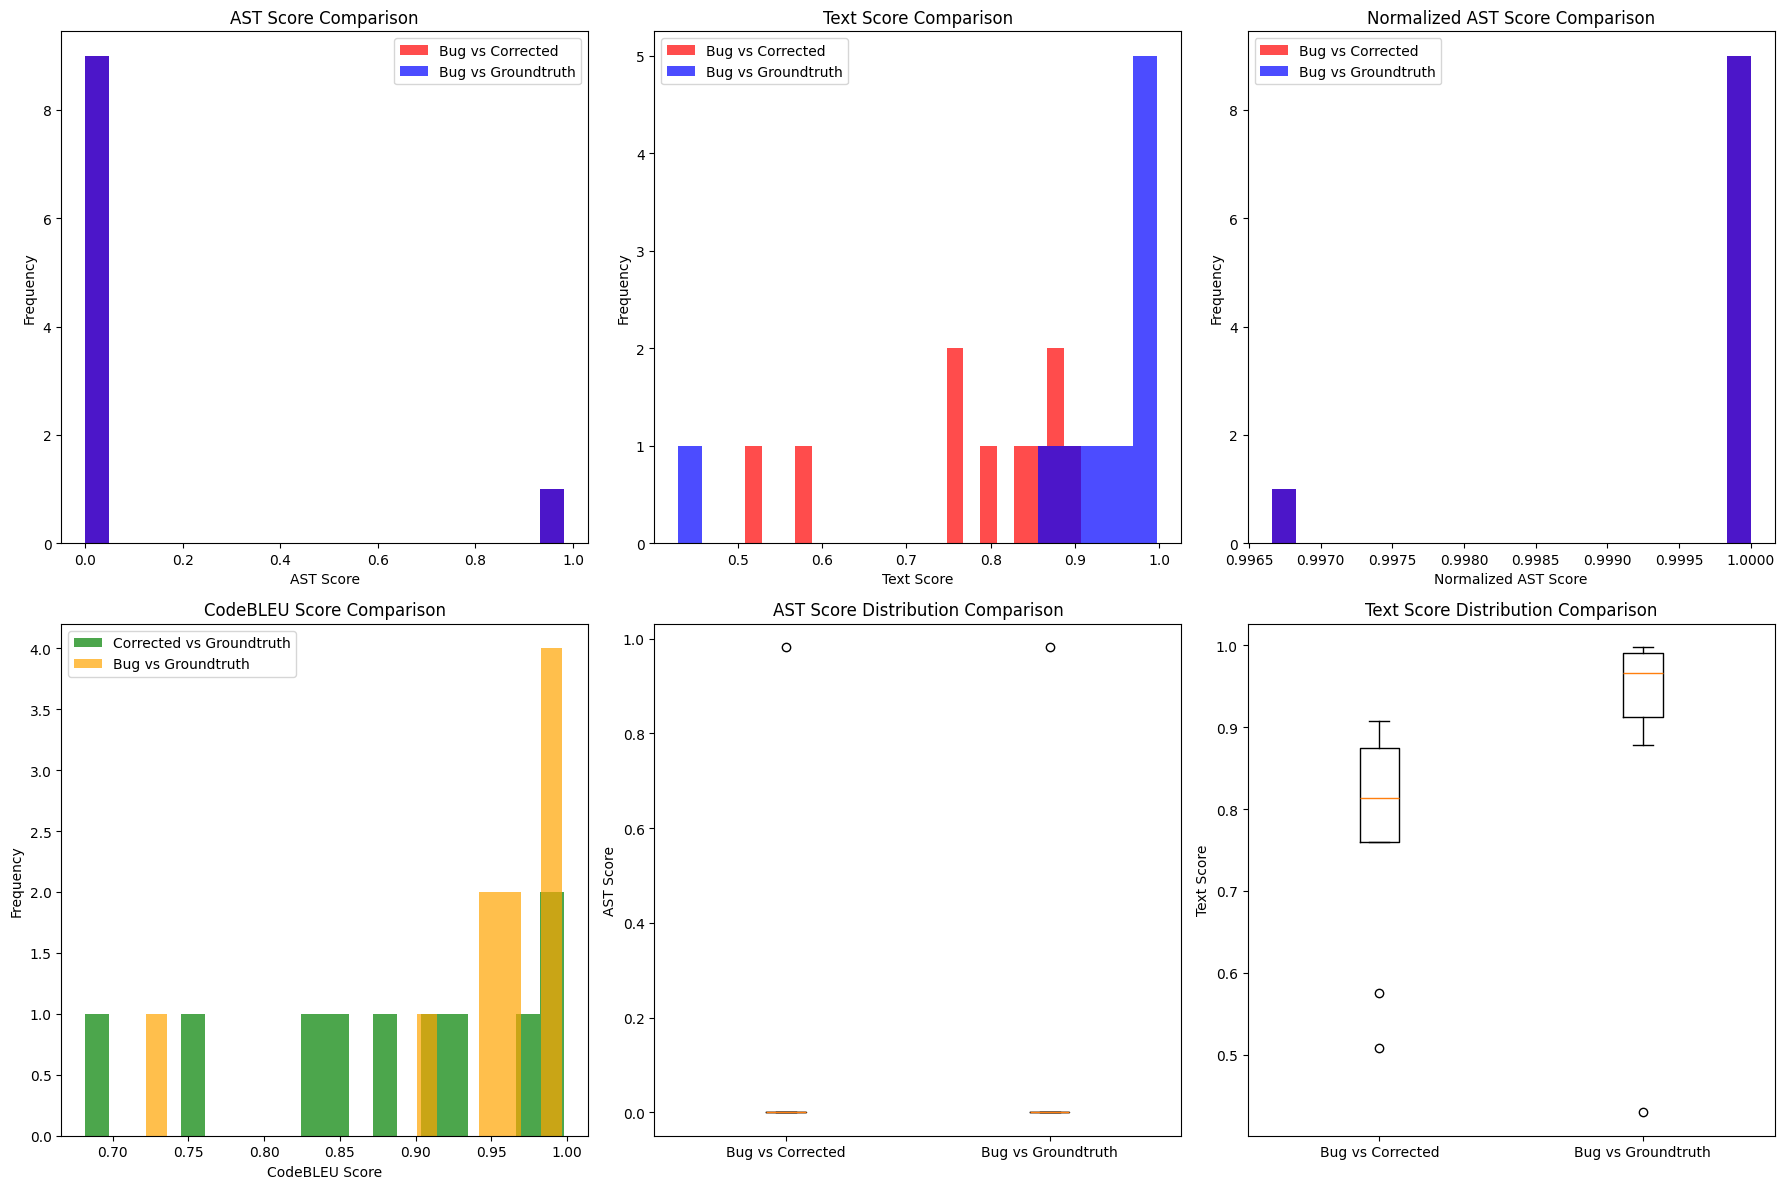

=== DIFF SCORE STATISTICS ===
AST Score - Bug vs Corrected: mean=0.098, std=0.295
AST Score - Bug vs Groundtruth: mean=0.098, std=0.295
Text Score - Bug vs Corrected: mean=0.776, std=0.127
Text Score - Bug vs Groundtruth: mean=0.904, std=0.163
Normalized AST Score - Bug vs Corrected: mean=1.000, std=0.001
Normalized AST Score - Bug vs Groundtruth: mean=1.000, std=0.001

=== CODEBLEU STATISTICS ===
CodeBLEU - Corrected vs Groundtruth: mean=0.880, std=0.098
CodeBLEU - Bug vs Groundtruth: mean=0.943, std=0.078


In [27]:
from utils.simple_metrics import diff_score, codebleu
def compare_metrics(buggy_codes, corrected_codes, groundtruth_codes):
    """Compare metrics between buggy, corrected, and groundtruth codes using histograms."""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Calculate diff scores (returns dict with ast_score, text_score, ast_score_normalized)
    bug_vs_corrected_diff = [diff_score(bug, corr) for bug, corr in zip(buggy_codes, corrected_codes)]
    bug_vs_groundtruth_diff = [diff_score(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Calculate codebleu scores
    corrected_vs_groundtruth_bleu = [codebleu(corr, gt) for corr, gt in zip(corrected_codes, groundtruth_codes)]
    bug_vs_groundtruth_bleu = [codebleu(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)]
    
    # Extract individual diff score components
    bug_vs_corrected_ast = [d['ast_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_text = [d['text_score'] for d in bug_vs_corrected_diff]
    bug_vs_corrected_ast_norm = [d['ast_score_normalized'] for d in bug_vs_corrected_diff]
    
    bug_vs_groundtruth_ast = [d['ast_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_text = [d['text_score'] for d in bug_vs_groundtruth_diff]
    bug_vs_groundtruth_ast_norm = [d['ast_score_normalized'] for d in bug_vs_groundtruth_diff]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Row 1: AST Score comparisons
    axes[0, 0].hist(bug_vs_corrected_ast, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 0].hist(bug_vs_groundtruth_ast, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 0].set_xlabel('AST Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('AST Score Comparison')
    axes[0, 0].legend()
    
    # Row 1: Text Score comparisons
    axes[0, 1].hist(bug_vs_corrected_text, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 1].hist(bug_vs_groundtruth_text, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 1].set_xlabel('Text Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Text Score Comparison')
    axes[0, 1].legend()
    
    # Row 1: Normalized AST Score comparisons
    axes[0, 2].hist(bug_vs_corrected_ast_norm, bins=20, alpha=0.7, label='Bug vs Corrected', color='red')
    axes[0, 2].hist(bug_vs_groundtruth_ast_norm, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='blue')
    axes[0, 2].set_xlabel('Normalized AST Score')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Normalized AST Score Comparison')
    axes[0, 2].legend()
    
    # Row 2: CodeBLEU comparisons
    axes[1, 0].hist(corrected_vs_groundtruth_bleu, bins=20, alpha=0.7, label='Corrected vs Groundtruth', color='green')
    axes[1, 0].hist(bug_vs_groundtruth_bleu, bins=20, alpha=0.7, label='Bug vs Groundtruth', color='orange')
    axes[1, 0].set_xlabel('CodeBLEU Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('CodeBLEU Score Comparison')
    axes[1, 0].legend()
    
    # Row 2: Box plot for AST scores
    axes[1, 1].boxplot([bug_vs_corrected_ast, bug_vs_groundtruth_ast], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 1].set_ylabel('AST Score')
    axes[1, 1].set_title('AST Score Distribution Comparison')
    
    # Row 2: Box plot for Text scores
    axes[1, 2].boxplot([bug_vs_corrected_text, bug_vs_groundtruth_text], 
                      labels=['Bug vs Corrected', 'Bug vs Groundtruth'])
    axes[1, 2].set_ylabel('Text Score')
    axes[1, 2].set_title('Text Score Distribution Comparison')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== DIFF SCORE STATISTICS ===")
    print(f"AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast):.3f}, std={np.std(bug_vs_corrected_ast):.3f}")
    print(f"AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast):.3f}, std={np.std(bug_vs_groundtruth_ast):.3f}")
    print(f"Text Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_text):.3f}, std={np.std(bug_vs_corrected_text):.3f}")
    print(f"Text Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_text):.3f}, std={np.std(bug_vs_groundtruth_text):.3f}")
    print(f"Normalized AST Score - Bug vs Corrected: mean={np.mean(bug_vs_corrected_ast_norm):.3f}, std={np.std(bug_vs_corrected_ast_norm):.3f}")
    print(f"Normalized AST Score - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_ast_norm):.3f}, std={np.std(bug_vs_groundtruth_ast_norm):.3f}")
    
    print("\n=== CODEBLEU STATISTICS ===")
    print(f"CodeBLEU - Corrected vs Groundtruth: mean={np.mean(corrected_vs_groundtruth_bleu):.3f}, std={np.std(corrected_vs_groundtruth_bleu):.3f}")
    print(f"CodeBLEU - Bug vs Groundtruth: mean={np.mean(bug_vs_groundtruth_bleu):.3f}, std={np.std(bug_vs_groundtruth_bleu):.3f}")

# Call the function with the lists
compare_metrics(buggy_codes, corrected_codes, groundtruth_codes)
